In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from numpy.linalg import pinv

In [2]:
BASE_PATH = r"C:\Users\Manaswini\Downloads\data"
SAVE_PATH = r"C:\Users\Manaswini\Downloads\anomaly\result_mset"

os.makedirs(SAVE_PATH, exist_ok=True)

In [3]:
FEATURES = [
    "Accelerometer1RMS",
    "Accelerometer2RMS",
    "Current",
    "Pressure",
    "Temperature",
    "Thermocouple",
    "Voltage",
    "Volume Flow RateRMS"
]


In [4]:
anomaly_free_path = os.path.join(
    BASE_PATH, "anomaly-free", "anomaly-free.csv"
)

df_normal = pd.read_csv(anomaly_free_path, sep=";")
df_normal["datetime"] = pd.to_datetime(df_normal["datetime"])
df_normal.set_index("datetime", inplace=True)

df_normal = df_normal[FEATURES]

print(df_normal.shape)
df_normal.head()

(9405, 8)


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664
2020-02-08 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338
2020-02-08 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338
2020-02-08 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664
2020-02-08 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normal = scaler.fit_transform(df_normal)

print(X_normal.shape)

(9405, 8)


In [6]:
import numpy as np
MEMORY_SIZE = 500  

np.random.seed(42)
memory_idx = np.random.choice(len(X_normal), MEMORY_SIZE, replace=False)

M = X_normal[memory_idx]   
print("Memory matrix shape:", M.shape)

Memory matrix shape: (500, 8)


In [7]:
from sklearn.metrics.pairwise import rbf_kernel

def mset_reconstruction(X, M, gamma=0.5):
    """
    X : samples to reconstruct
    M : memory matrix
    """
    K = rbf_kernel(X, M, gamma=gamma)
    
    K_norm = K / (K.sum(axis=1, keepdims=True) + 1e-8)
    
    X_hat = K_norm @ M
    return X_hat

In [8]:
X_hat_normal = mset_reconstruction(X_normal, M, gamma=0.5)

recon_error_normal = np.linalg.norm(X_normal - X_hat_normal, axis=1)

print(recon_error_normal.mean())
print(recon_error_normal.std())
print(recon_error_normal.max())

THRESHOLD = recon_error_normal.mean() + 3 * recon_error_normal.std()
print(THRESHOLD)

1.1140676841761727
0.3440594371258448
4.4715647806156555
2.1462459955537074


In [9]:
fault_folders = {
    "valve1": list(range(16)),
    "valve2": list(range(4)),
    "other": list(range(1, 15)) 
}

results = []

for folder, file_ids in fault_folders.items():
    folder_path = os.path.join(BASE_PATH, folder)

    for i in file_ids:
        file_path = os.path.join(folder_path, f"{i}.csv")

        df_fault = pd.read_csv(file_path, sep=";")
        df_fault["datetime"] = pd.to_datetime(df_fault["datetime"])
        df_fault.set_index("datetime", inplace=True)

        X_fault = scaler.transform(df_fault[FEATURES])

        X_hat_fault = mset_reconstruction(X_fault, M, gamma=0.5)
        recon_error = np.linalg.norm(X_fault - X_hat_fault, axis=1)

        anomaly_ratio = (recon_error > THRESHOLD).mean()

        results.append({
            "Folder": folder,
            "File": f"{i}.csv",
            "Mean_Error": recon_error.mean(),
            "Max_Error": recon_error.max(),
            "Anomaly_Ratio": anomaly_ratio
        })

        print(f"{folder} file {i}.csv | Anomaly ratio: {anomaly_ratio:.3f}")


valve1 file 0.csv | Anomaly ratio: 1.000
valve1 file 1.csv | Anomaly ratio: 1.000
valve1 file 2.csv | Anomaly ratio: 1.000
valve1 file 3.csv | Anomaly ratio: 1.000
valve1 file 4.csv | Anomaly ratio: 1.000
valve1 file 5.csv | Anomaly ratio: 1.000
valve1 file 6.csv | Anomaly ratio: 1.000
valve1 file 7.csv | Anomaly ratio: 1.000
valve1 file 8.csv | Anomaly ratio: 1.000
valve1 file 9.csv | Anomaly ratio: 1.000
valve1 file 10.csv | Anomaly ratio: 1.000
valve1 file 11.csv | Anomaly ratio: 1.000
valve1 file 12.csv | Anomaly ratio: 1.000
valve1 file 13.csv | Anomaly ratio: 1.000
valve1 file 14.csv | Anomaly ratio: 1.000
valve1 file 15.csv | Anomaly ratio: 1.000
valve2 file 0.csv | Anomaly ratio: 1.000
valve2 file 1.csv | Anomaly ratio: 1.000
valve2 file 2.csv | Anomaly ratio: 1.000
valve2 file 3.csv | Anomaly ratio: 1.000
other file 1.csv | Anomaly ratio: 1.000
other file 2.csv | Anomaly ratio: 1.000
other file 3.csv | Anomaly ratio: 1.000
other file 4.csv | Anomaly ratio: 1.000
other file 5.c

In [10]:
import joblib
metrics_df = pd.DataFrame(results)
metrics_df.to_csv(os.path.join(SAVE_PATH, "mset_metrics.csv"), index=False)

joblib.dump({
    "scaler": scaler,
    "memory_matrix": M,
    "threshold": THRESHOLD,
    "features": FEATURES
}, os.path.join(SAVE_PATH, "mset_pipeline.pkl"))

['C:\\Users\\Manaswini\\Downloads\\anomaly\\result_mset\\mset_pipeline.pkl']

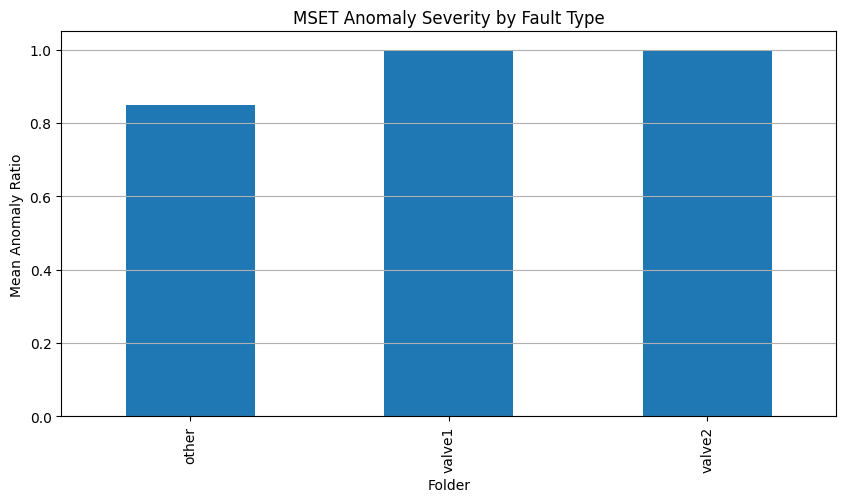

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
metrics_df.groupby("Folder")["Anomaly_Ratio"].mean().plot(kind="bar")
plt.ylabel("Mean Anomaly Ratio")
plt.title("MSET Anomaly Severity by Fault Type")
plt.grid(axis="y")
plt.show()

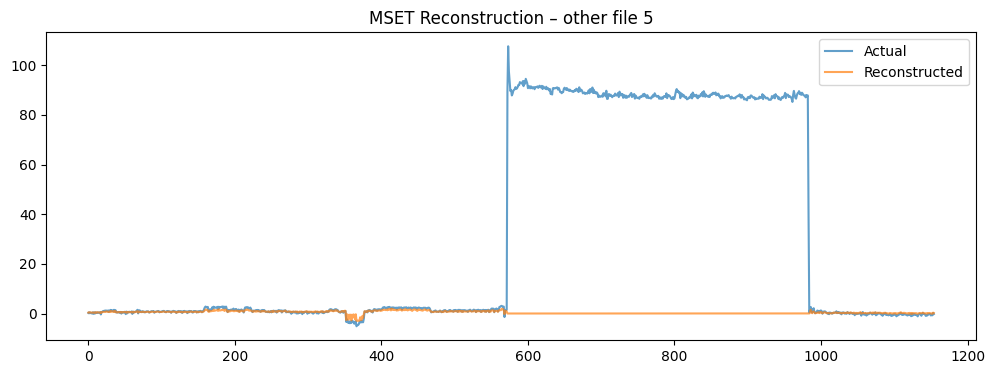

In [12]:
folder = "other"
file_id = 5

file_path = os.path.join(BASE_PATH, folder, f"{file_id}.csv")

df_fault = pd.read_csv(file_path, sep=";")
df_fault["datetime"] = pd.to_datetime(df_fault["datetime"])
df_fault.set_index("datetime", inplace=True)

X_fault = scaler.transform(df_fault[FEATURES])
X_hat = mset_reconstruction(X_fault, M)

plt.figure(figsize=(12,4))
plt.plot(X_fault[:, 0], label="Actual", alpha=0.7)
plt.plot(X_hat[:, 0], label="Reconstructed", alpha=0.7)
plt.title(f"MSET Reconstruction – {folder} file {file_id}")
plt.legend()
plt.show()